# 分析是否具有核保循環

PDF 台灣商業個人健康保險之核保循環 P9-16

Step 1 : 先變數定義與描述性統計看 損失率、保費收入、賠款給付的平均值、中位數、Skew、Kurtosis、Min、Max跟Obs
Step 2 : 單根檢定 含截距項與時間趨勢項 和 僅含截距項 兩種情況分別作 ADF檢定與 PP檢定
Step 3 : 若 ADF檢定與PP檢定不一致，用Zivot與Adrews結構轉變單根檢定損失率單根是否由結構轉變穩定數列引起，找出結構轉變時間點

Step 4 (若檢定結果不一致才需要) : 
    先用Chow檢定和轉換迴歸檢定，找損失率使否具有結構轉換
    再用Zivot 跟 Andrew 檢定找出結構轉換時間點

Step 5 :
    若有因結構改變產生單根現象，以結構轉換點把母樣本切分為多個子樣本，
    再用AR(2)模型檢測子樣本是否具有核保循環，並用 MS-AR(2)探討整體樣本是否存在兩狀態循環
    再用AR(2)模型檢測整個樣本是否具有核保循環

    AR(2)模型 : LRt =α2 +α1 LRt-1 +α2 LRt-2 +ωt
        LR 為損失率，α1、α2 分別為損失率落後期 1、2 的係數，α0 為常數項，ω 為誤差項
        
    Venezian (1985)簡化AR(2)模型，損失率或核保利潤率落後項係數必須顯著，
    滿足 α1 ＞ 0,α2 ＜ 0 與 α2^2 + 4α2 ＜ 0 的條件，得出核保循環週期為 2pi/(cos^(-1)( a1/2sqirt(a2) ))
    
    MS-AR(2): 
        LRt =β0_st+ β 1_st*LRt-1 + β2_st*LRt-2 + εst
        LRt 為第 t 期損失率。st 為不可觀察的二元狀態變數，值為 1 或 2
    
    樣本數較小: 用Gibbs Sampling 進行 MS 模型估計
    若不存在MS-AR(2)，P(st=1|st-1=1) = P(st=1|st-1=2) 
    
    檢定量為 H0 : P11+P22=1
        H0^2/ [Var(P11)+Var(P22)-2cov(P11,P22)] 是否為卡方分布
        是卡方分布，接受虛無假設，非卡方分布，拒絕虛無假設，損失率動態結構可區分兩種狀態

Step 6 : 
    E(LR_st) = B0_st/(1-B1_st-B2_st)

In [1]:
import pandas as pd
df = pd.read_excel("火險資料精簡版_model_use.xlsx",header =0, index_col=0)

def status(x) : 
    return pd.Series([x.count(),x.min(),x.idxmin().astype(str),x.quantile(.25),x.median(),
                      x.quantile(.75),x.mean(),x.max(),x.idxmax().astype(str),x.mad(),x.var(),
                      x.std(),x.skew(),x.kurt()],index=['總數','最小值','最小值位置','25%分位數',
                    '中位數','75%分位數','均值','最大值','最大值位數','平均絕對偏差','方差','標準差','偏度','峰度'])
df.apply(status) #.to_excel('describe_data.xlsx')

,當年簽單保費,滿期保費,已發生賠款,損失率
總數,20,20,20,20
最小值,10635143916,10090205387,3032008484,0.121283
最小值位置,2000,2000,2003,2003
25%分位數,1.70937e+10,1.81248e+10,4.87447e+09,0.21966
中位數,1.86575e+10,1.98803e+10,5.49343e+09,0.30882
75%分位數,2.04139e+10,2.13574e+10,7.44796e+09,0.435942
均值,1.83391e+10,1.92073e+10,7.65635e+09,0.430685
最大值,22717960326,24999360892,26010542819,1.38721
最大值位數,2003,2003,2016,2001
平均絕對偏差,2.28357e+09,2.56917e+09,3.87169e+09,0.251514


In [5]:
df.index = df.index.astype(str)

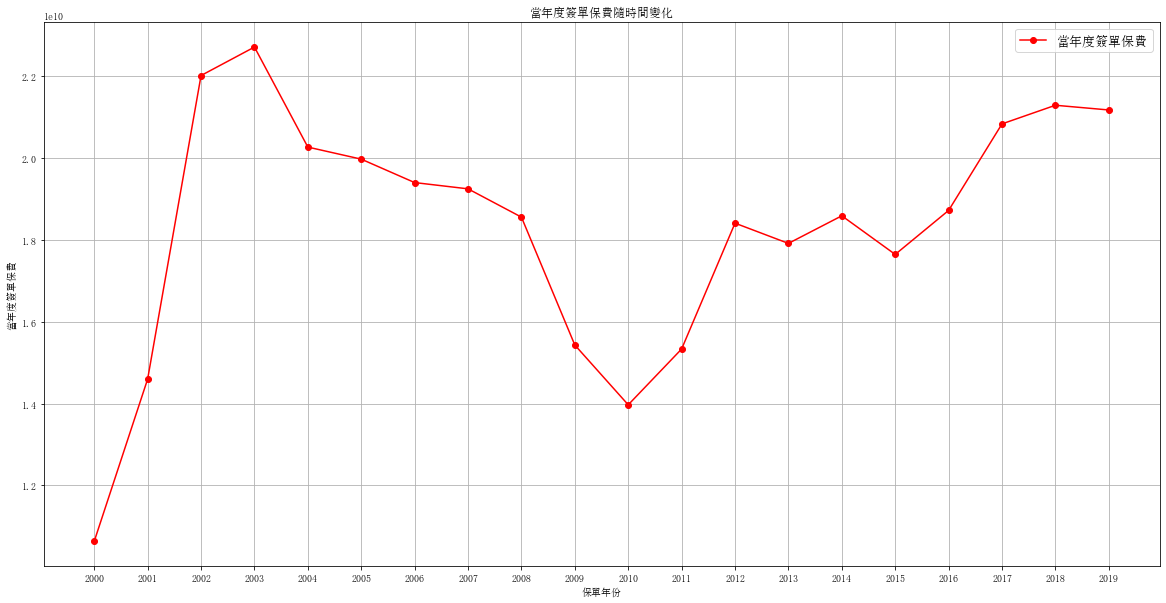

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# 當年簽單保費繪圖
plt.rcParams['font.family'] = 'SimSun' # 解決中文字問題，選擇能商用字體才安心
plt.rcParams["figure.figsize"] = (20,10)

y = df.index #.astype(str)
x1 = df['當年簽單保費']
plt.plot(y,x1, color='red',label='當年度簽單保費',marker = "o")
plt.title('當年度簽單保費隨時間變化')

plt.legend(loc='best',prop={'size': 13})
plt.xlabel('保單年份')
plt.ylabel('當年度簽單保費')
plt.grid()

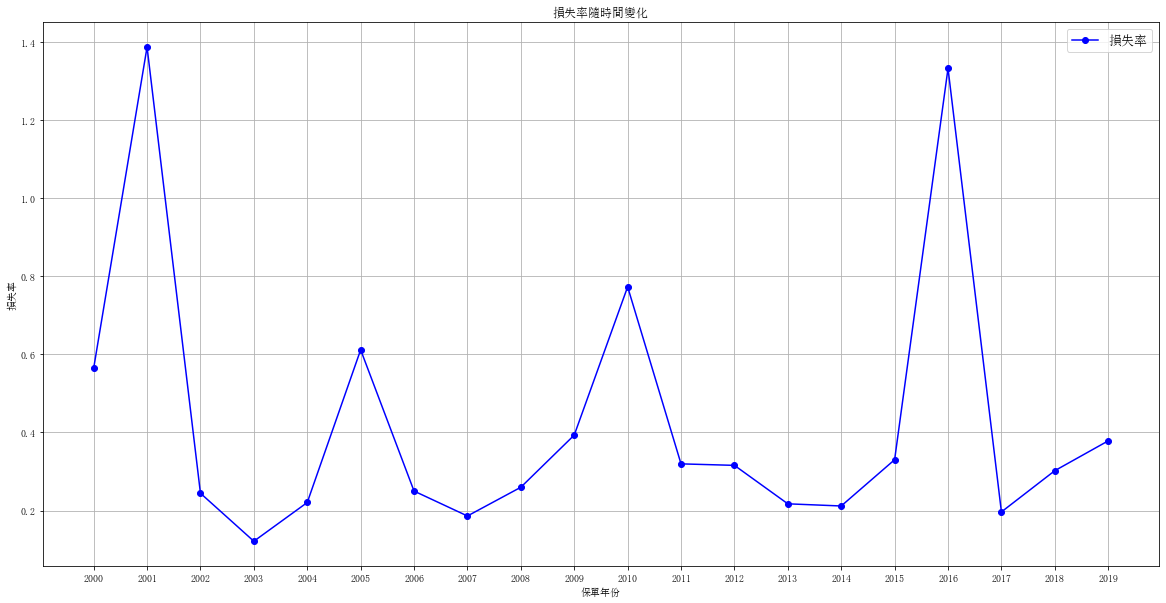

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# 損失率繪圖
plt.rcParams['font.family'] = 'SimSun' # 解決中文字問題，選擇能商用字體才安心
plt.rcParams["figure.figsize"] = (20,10)

y = df.index.astype(str)
x = df['損失率']
plt.plot(y,x, color='blue',label='損失率',marker = "o")
plt.title('損失率隨時間變化')

plt.legend(loc='best',prop={'size': 13})
plt.xlabel('保單年份')
plt.ylabel('損失率')
plt.grid()

In [8]:
# ADF 檢定
# https://kknews.cc/zh-tw/code/6z3m9av.html
# 虛無假設：序列有一個單位根(a=1的值)    備擇假設：該序列沒有單位根

# Define function for ADF test
from statsmodels.tsa.stattools import adfuller

# x: 一維數據序列，maxlag:最大滯留樹木，
#     regression(c:只有常數項，默認 ,ct: 常數項和趨勢項, ctt:常數項 + 線性迴歸二次項, nc:沒有常數項和趨勢項)
# autolag : 
# 自動選擇滯後數目(AIC: 赤池信息準則，默認, BIC:貝葉斯信息準則，
#             t-stat:基於maxlag，從maxlag開始並刪除一個滯後直到最後一個滯後長度基於 t-statisitc顯著性小於5%為止，
#             None: 使用maxlag指定滯後)
# store : True or False，默認項，regresults：True 完整把回歸結果返回，False: 默認

# 返回值定義 : 
# adf：Test statistic，T检验，假设检验值。 pvalue：假设检验结果 usedlag：使用的滞后阶数。
# nobs：用于ADF回归和计算临界值用到的观测值数目
# icbest：如果autolag不是None的话，返回最大的信息准则值
# resstore：将结果合并为一个dummy

# Define function for ADF test
def adf_test(timeseries,c):
    # Perform Dickey-Fuller test
    dic ={'c':'僅包含截距項','ct': '包含截距項和趨勢項','ctt':'包含常數項和線性迴歸二次項','nc':'沒有常數項和趨勢項'}
    print('Regression :', dic[c])
    print("Result of Dickey-Fuller test: ")
    dftest = adfuller(timeseries, autolag="AIC",regression=c)
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','P-value',"Lags Used",'Number of Obsercations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value {}'.format(key)] = value
    print(dfoutput)
        

# 僅含截距項
adf_test(df['損失率'],'c') # c:只有常數項，默認 ,ct: 常數項和趨勢項, ctt:常數項 + 線性迴歸二次項, nc:沒有常數項和趨勢項
print('==============')
# 含截距項和趨勢項
adf_test(df['損失率'],'ct')

Regression : 僅包含截距項
Result of Dickey-Fuller test: 
Test Statistic                  0.007382
P-value                         0.959138
Lags Used                       8.000000
Number of Obsercations Used    11.000000
Critical Value 1%              -4.223238
Critical Value 5%              -3.189369
Critical Value 10%             -2.729839
dtype: float64
Regression : 包含截距項和趨勢項
Result of Dickey-Fuller test: 
Test Statistic                 -5.588618
P-value                         0.000015
Lags Used                       7.000000
Number of Obsercations Used    12.000000
Critical Value 1%              -4.988248
Critical Value 5%              -3.865365
Critical Value 10%             -3.382725
dtype: float64


第一個值: T值，第二個值P-value為T值對應概率值，第三個Lags Used表示延遲，第四個值Number of Obsercations Used表示測試次數

1%、5%、10%代表在99%，95%，90%置信区间下的临界的ADF检验所得出的T值，左尾檢定

    ADF 第一個值 Test Statistic 值 同时大于1%、5%、10% 的 T值 無法拒絕虛無假設，反之則可拒絕虛無假設
    P-value 是否接近零，接近零，拒絕虛無假設為平穩的， 否則，不平穩

https://kknews.cc/zh-tw/tech/6arq3lm.html
這次的模型結果

    僅包含截距項 Test Statistic 0.007382 值 大於 1%、5%、10% T值[-4.223238,-3.189369,-2.729839]，
    無法拒絕虛無假設，且P-value不接近0 [0.959138]，時間序列為不平穩的
    包含截距項 Test Statistic 小於 1%、5%、10% T值，拒絕虛無假設，且P-value接近0，時間序列為平穩的

In [9]:
# !pip install arch
# https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.PhillipsPerron.html
from arch.unitroot import PhillipsPerron

# Define function for PP test
def pp_test(timeseries,c):
    # Perform Phillips-Perron test
    dic ={'c':'僅包含截距項','ct': '包含截距項和趨勢項','n':'No trend components'}
    print('Regression :', dic[c])
    pp = PhillipsPerron(timeseries)
    # 可調整 lag
    # pp.lags= 12
    # pp.test_type = "rho"
    pp.trend = c
    print(pp.summary().as_text())
    
# 僅含截距項
pp_test(df['損失率'],'c') 
# “c” - Include a constant (Default) ,“ct” - Include a constant and linear time trend, “n” - No trend components
print('===========================')
# 含截距項和趨勢項
pp_test(df['損失率'],'ct')

Regression : 僅包含截距項
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.225
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.83 (1%), -3.03 (5%), -2.66 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Regression : 包含截距項和趨勢項
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.839
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.53 (1%), -3.67 (5%), -3.28 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


D:\Anaconda3\lib\site-packages\arch\unitroot\unitroot.py:650: FutureWarning: Mutating unit root tests is deprecated and will raise an error in the first release of arch 5.x after August 2020. Create new test objects to change test parametrization.

  warnings.warn(MUTATING_WARNING, FutureWarning)


In [10]:
# Zivot 與 Andrews 檢定 ## bug 太多，改用 R 處理
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.zivot_andrews.html
# https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ZivotAndrews.html

# 樣本過小無法使用 zivot Andrews test
# Define function for ZivotAndrews test
# def ZivotAndrews_test(timeseries,c):
#     from arch.unitroot import ZivotAndrews
#     # Perform ZivotAndrews test
#     dic ={'c':'僅包含截距項','ct': '包含截距項和趨勢項','t':'僅包含趨勢項'}
#     print('Regression :', dic[c])
#     za = ZivotAndrews(timeseries,trim=0.001,max_lags=1)
#     # 可調整 lag
#     # pp.lags= 12
#     # pp.test_type = "rho"
#     za.trend = c
#     print(za.summary().as_text())
    
# # 僅含截距項
# ZivotAndrews_test(df['損失率'],'c') 
# # “c” - Include a constant (Default) ,“ct” - Include a constant and linear time trend, “n” - No trend components
# print('===========================')
# # 含截距項和趨勢項
# ZivotAndrews_test(df['損失率'],'ct')


# Define function for ZivotAndrews test
# def zivot_andrew(ts,c): #
#     from statsmodels.tsa.stattools import zivot_andrews
#     # Perform ZivotAndrews test
#     dic ={'c':'僅包含截距項','ct': '包含截距項和趨勢項','t':'僅包含趨勢項'}
#     print('Regression :', dic[c])
#     print("Result of Dickey-Fuller test: ")
#     dftest = zivot_andrews(ts,regression=c,autolag =None)
#     dfoutput = pd.Series(dftest,index=['Test Statistic','P-value',"cvdict",'bpidx','baselag'])
    
#     for key, value in dftest["cvdict"].items():
#         dfoutput['Critical Value {}'.format(key)] = value
#     print(dfoutput)
    
# 僅含截距項 
# zivot_andrew(df['損失率'],'c') 
# 含截距項和趨勢項
# zivot_andrew(df['損失率'],'ct') 

D:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


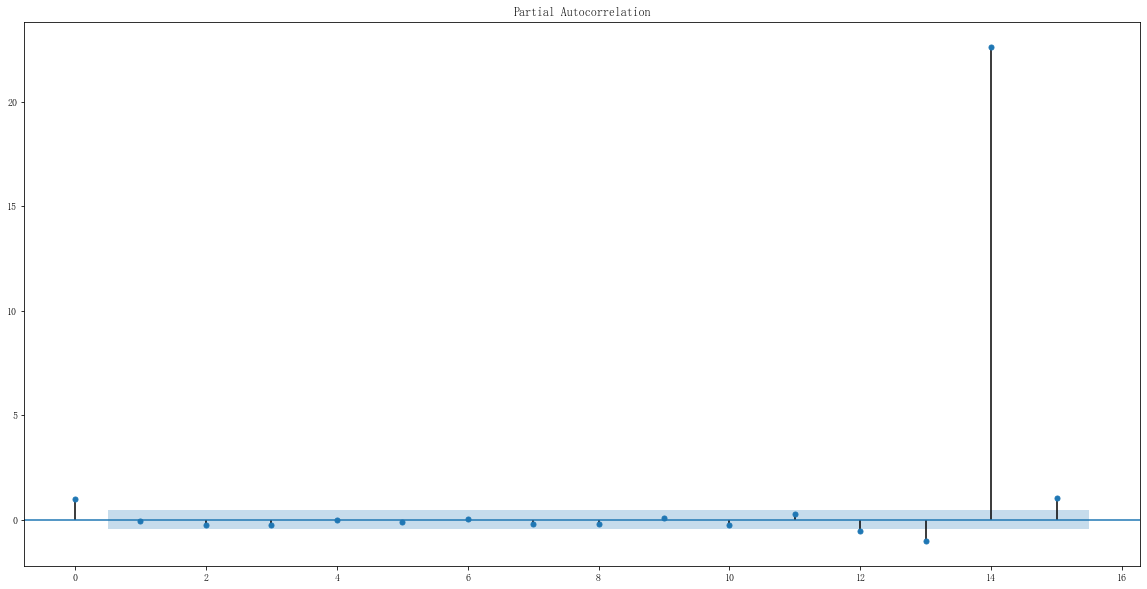

In [2]:
# ? 如何用 zivot_andrew 判斷斷點?
# 依據 Zivot_andrew test 再加上網路猜測，判斷 Position 4 有斷點

## AR(2) model
# AR(2)模型 : LRt =α2 +α1 LRt-1 +α2 LRt-2 +ωt
#     LR 為損失率，α1、α2 分別為損失率落後期 1、2 的係數，α0 為常數項，ω 為誤差項

# Venezian (1985)簡化AR(2)模型，損失率或核保利潤率落後項係數必須顯著，
# 滿足 α1 ＞ 0,α2 ＜ 0 與 α2^2 + 4α2 ＜ 0 的條件，得出核保循環週期為 2pi/(cos^(-1)( a1/2sqirt(a2) ))
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# 損失率繪圖
plt.rcParams['font.family'] = 'SimSun' # 解決中文字問題，選擇能商用字體才安心
plt.rcParams["figure.figsize"] = (20,10)

# plot partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['損失率'],lags=15) #, lags=10

D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


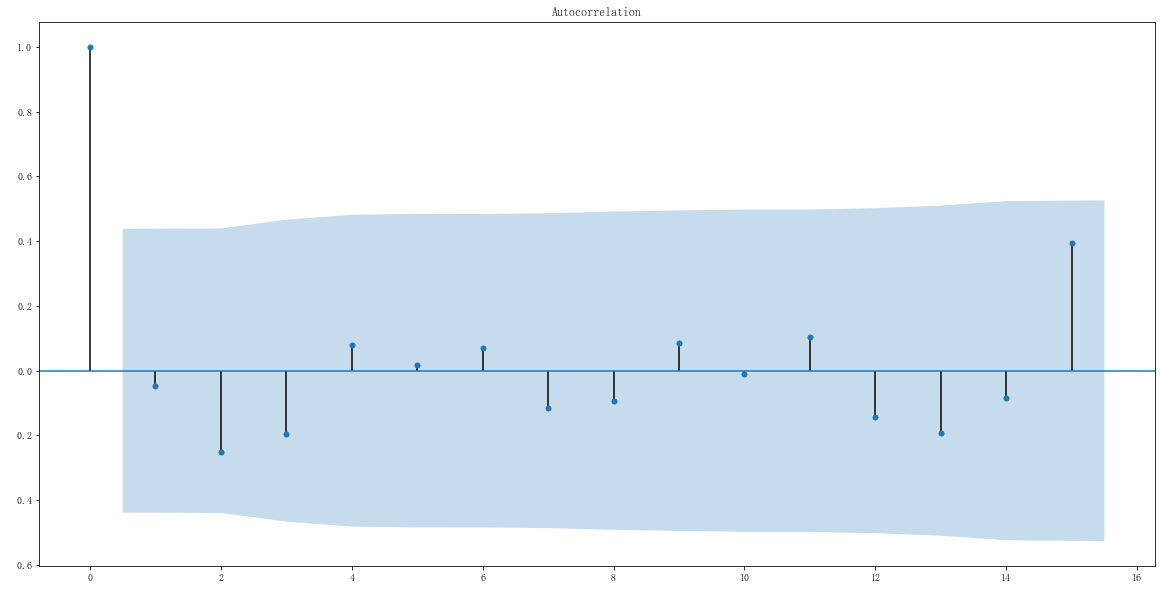

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# 損失率繪圖
plt.rcParams['font.family'] = 'SimSun' # 解決中文字問題，選擇能商用字體才安心
plt.rcParams["figure.figsize"] = (20,10)

# plot acf
from statsmodels.graphics.tsaplots import plot_acf
pacf = plot_acf(df['損失率'],lags=15) #, lags=10

In [12]:
## AR(2) model ## 全部
# AR(2)模型 : LRt =α2 +α1 LRt-1 +α2 LRt-2 +ωt
#     LR 為損失率，α1、α2 分別為損失率落後期 1、2 的係數，α0 為常數項，ω 為誤差項
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df['損失率'], lags=2).fit()
print(ar_model.summary())

# Make the predictions  ## 有切資料才要用，這裡不需要
# pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
# #
# # Plot the prediction vs test data
# #
# from matplotlib import pyplot
# pyplot.plot(pred)
# pyplot.plot(test_data, color='red')

                            AutoReg Model Results                             
Dep. Variable:                    損失率   No. Observations:                   20
Model:                     AutoReg(2)   Log Likelihood                  -1.298
Method:               Conditional MLE   S.D. of innovations              0.260
Date:                Sun, 20 Jun 2021   AIC                             -2.249
Time:                        00:10:12   BIC                             -2.051
Sample:                    01-01-2002   HQIC                            -2.222
                         - 01-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5331      0.123      4.348      0.000       0.293       0.773
損失率.L1        -0.1177      0.169     -0.697      0.486      -0.449       0.213
損失率.L2        -0.2560      0.169     -1.515      0.1

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [7]:
## 用 zivot/Andrews test both 加上網路資料，推測斷點可能在2003 [ position 4 ]
## 2000-2003 ## 樣本過少，無法做 AR(2)
# 個別 子樣本 AR(2)
# ar_model2003 = AutoReg(df['損失率'].iloc[:4], lags=2).fit()
# print('2000-2003: ',ar_model2015.summary())

## 2004-2019  
ar_model2019 = AutoReg(df['損失率'].iloc[4:], lags=2).fit()
print('2004-2019: ',ar_model2019.summary())

2004-2019:                              AutoReg Model Results                             
Dep. Variable:                    損失率   No. Observations:                   16
Model:                     AutoReg(2)   Log Likelihood                  -2.296
Method:               Conditional MLE   S.D. of innovations              0.285
Date:                Sat, 19 Jun 2021   AIC                             -1.938
Time:                        23:54:46   BIC                             -1.756
Sample:                             2   HQIC                            -1.955
                                   16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5561      0.174      3.198      0.001       0.215       0.897
損失率.L1        -0.1668      0.255     -0.653      0.514      -0.667       0.334
損失率.L2        -0.2442      0.253     -0.

In [15]:
# ? switch variance

# https://www.statsmodels.org/devel/examples/notebooks/generated/markov_autoregression.html
# https://zhuanlan.zhihu.com/p/149180436

# The default model also includes switching autoregressive coefficients, so here we also need to specify switching_ar=False to avoid that

# MS-AR(2): 
#     LRt =β0_st+ β 1_st*LRt-1 + β2_st*LRt-2 + εst
#     LRt 為第 t 期損失率。st 為不可觀察的二元狀態變數，值為 1 或 2
import statsmodels.api as sm

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(df['損失率'], k_regimes=2, order=2, switching_ar=False)
res_hamilton = mod_hamilton.fit()

res_hamilton.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      損失率   No. Observations:                   18
Model:             MarkovAutoregression   Log Likelihood                  -1.298
Date:                  Sun, 20 Jun 2021   AIC                             16.595
Time:                          00:11:12   BIC                             22.828
Sample:                      01-01-2000   HQIC                            17.454
                           - 01-01-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3881      0.476      0.816      0.414      -0.544       1.320
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3881        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0676      0.023      3.000      0.003       0.023       0.112
ar.L1         -0.1177      0.169     -0.697      0.486      -0.449       0.213
ar.L2         -0.2560      0.169     -1.515      0.130      -0.587       0.075
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1517   1.06e+05   1.43e-06      1.000   -2.08e+05    2.08e+05
p[1->0]        0.1820   4.18e+04   4.36e-06      1.000   -8.18e+04    8.18e+04
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


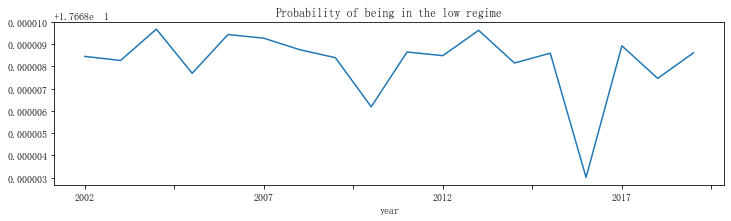

In [16]:
# https://blog.csdn.net/ndhtou222/article/details/106846510
res_hamilton.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the low regime', figsize=(12,3))

D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


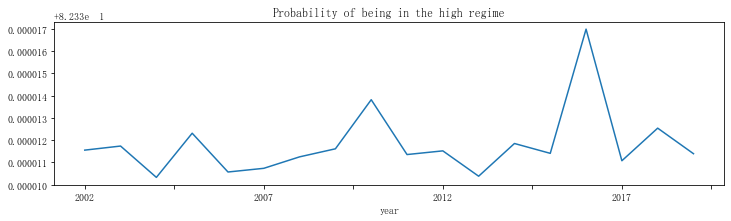

In [17]:
res_hamilton.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,3))

In [18]:
# ? filter marginal probabilities是甚麼
# res_hamilton.filtered_marginal_probabilities[0]

print(res_hamilton.expected_durations)

[1.17889575 5.49328588]


In [ ]:
## 台幣美元匯率圖

# import pandas as pd
# import sqlite3
# import datetime
# import os
# conn = sqlite3.connect(os.path.join('data', "twse.db"))

# # 取 美元／新台幣
# sql_a=("""select date,stock_id, %s FROM %s ORDER BY DATE DESC """%('美元／新台幣','forex_price'))
# df1 = (pd.read_sql(sql_a, conn, index_col=['date'], parse_dates=['date']))

# # 畫圖
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'SimSun'
# plt.rcParams["figure.figsize"] = (20,10)
# df1['2019-05-01':'2017-01-01'].plot(label='美元兌台幣幣值',marker='o')
# plt.legend(loc='best',prop={'size': 15})

# plt.title('美元兌台幣走勢圖')                     #設定圖形標題
# plt.ylabel('轉換匯率')                             #設定 Y 軸標籤
# plt.xlabel('時間')
# plt.grid()